In [2]:
# [기본 세팅] ------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# 윈도우 한글 폰트 + 마이너스 표시 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 표시에 도움되는 옵션 (너무 길게 줄바꿈되는 것 방지)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

print("✅ 기본 세팅 완료")

✅ 기본 세팅 완료


In [3]:
# === [번들에서 복원] ===
import pickle

BUNDLE_PATH = "_snapshots/olist_clean_bundle.pkl"

with open(BUNDLE_PATH, "rb") as f:
    bundle = pickle.load(f)

# 변수로 바로 풀어서 사용
orders_clean       = bundle["orders_clean"]
order_items_clean  = bundle["order_items_clean"]
payments_clean     = bundle["payments_clean"]
reviews_clean      = bundle["reviews_clean"]
customers_clean    = bundle["customers_clean"]
geolocation_clean  = bundle["geolocation_clean"]
products_clean     = bundle["products_clean"]
sellers_clean      = bundle["sellers_clean"]
category_tr_clean  = bundle["category_tr_clean"]

print("✅ Restored all *_clean DataFrames")


✅ Restored all *_clean DataFrames


In [4]:
# =========================================================
# (1) 가드 & 옵션
# - 필수 DF가 모두 메모리에 있는지 체크
# - FAST_MODE: True면 가중치 최적화 생략(고정 가중치 사용)
# =========================================================
_need = {"orders_clean","payments_clean","customers_clean"}
_missing = [x for x in _need if x not in globals()]
if _missing:
    raise NameError(f"다음 DataFrame이 필요합니다: {_missing}")

FAST_MODE = False  # True: 빠른 실행(가중치 고정), False: 원본처럼 최적화 수행


In [5]:
# =========================================================
# (2) RFM 베이스 (배송완료 주문만 사용)
# - 주문(od) + 고객(oc) 결합
# - 결제금액은 order_id별 합계 후 고객 고유ID 단위로 집계
# =========================================================

# 2-1) 배송완료 주문만 추출
od = orders_clean.loc[
    orders_clean["order_status"]=="delivered",
    ["order_id","customer_id","order_purchase_timestamp"]
].dropna(subset=["order_purchase_timestamp"])

# 2-2) 고객 정보 붙이기 (고객 고유ID, 주(state))
oc = customers_clean[["customer_id","customer_unique_id","customer_state"]]
od = od.merge(oc, on="customer_id", how="left")

# 2-3) Recency 계산
_base_date = od["order_purchase_timestamp"].dt.date.max()         # 기준일 = 마지막 구매일(일자)
_last_dt   = od.groupby("customer_unique_id")["order_purchase_timestamp"].max().dt.date
rfm_recency = (pd.to_datetime(_base_date) - pd.to_datetime(_last_dt)).dt.days + 1
rfm_recency.name = "Recency_days"

# 2-4) Frequency = 고객의 주문 건수
rfm_freq = od.groupby("customer_unique_id")["order_id"].nunique().rename("Frequency")

# 2-5) Monetary = 결제금액 합
pay_per_order = payments_clean.groupby("order_id")["payment_value"].sum().rename("pay_sum")
od_pay = od.merge(pay_per_order, on="order_id", how="left")
rfm_m_raw = od_pay.groupby("customer_unique_id")["pay_sum"].sum().fillna(0.0).rename("Monetary_raw")

# 2-6) Monetary 윈저화(극단값 완화)
def _winsorize(s, lo=0.01, hi=0.99):
    x = pd.to_numeric(s, errors="coerce")
    ql, qh = x.quantile(lo), x.quantile(hi)
    return x.clip(ql, qh)

rfm_m = _winsorize(rfm_m_raw, 0.01, 0.99).rename("Monetary")

# 2-7) 고객 주(state)
rfm_state = od.groupby("customer_unique_id")["customer_state"].first().rename("customer_state")

# 2-8) 최종 RFM 베이스
rfm = pd.concat([rfm_recency, rfm_freq, rfm_m_raw, rfm_m, rfm_state], axis=1).reset_index()


In [6]:
# =========================================================
# (3) 점수화
# - Recency: 하이브리드 구간(5개) → 최근일수 작을수록 높은 점수(5)
# - Frequency/Monetary: rank+qcut으로 5분위
# =========================================================
def _recency_hybrid_bins(rdays, round_to=5):
    x = pd.to_numeric(rdays, errors="coerce").dropna()
    qs = x.quantile([.2,.4,.6,.8]).values.tolist()                # 사분위 유사 5구간
    qs_round = [int(round(v/round_to)*round_to) for v in qs]      # 5일 단위 반올림
    # 경계 중복 방지(단조 증가)
    for i in range(1,len(qs_round)):
        if qs_round[i] <= qs_round[i-1]:
            qs_round[i] = qs_round[i-1] + round_to
    bins = [-np.inf] + qs_round + [np.inf]
    return bins, [5,4,3,2,1]  # 작을수록 최근 → 높은 점수

bins_r, labels_r = _recency_hybrid_bins(rfm["Recency_days"], 5)
rfm["R_score"] = pd.cut(rfm["Recency_days"], bins=bins_r, labels=labels_r, include_lowest=True).astype(int)

def _score_q5(s, labels=(1,2,3,4,5)):
    r = pd.to_numeric(s, errors="coerce").rank(method="first")
    return pd.qcut(r, q=len(labels), labels=labels).astype(int)

rfm["F_score"] = _score_q5(rfm["Frequency"], (1,2,3,4,5))
rfm["M_score"] = _score_q5(rfm["Monetary"],  (1,2,3,4,5))

# 검증: Recency=1인 고객의 점수는 5여야 함
_chk = rfm.loc[rfm["Recency_days"]==1, "R_score"]
if not _chk.empty and int(_chk.mode().iloc[0]) != 5:
    raise AssertionError("R_score 방향 오류: Recency_days=1 고객의 R_score는 5여야 합니다.")


In [7]:
# =========================================================
# (4) 가중치 결정
# - 기본: 원본처럼 간단 그리드 서치(제약 R≥F≥M, 합=1)로 lift/순위상관 최대화
# - FAST_MODE=True면 고정 가중치 사용(예: R=0.45, F=0.35, M=0.20)
# =========================================================
def _class_from_scores(scores, q=5):
    ranks = pd.Series(scores).rank(method="first", ascending=False)
    return pd.qcut(ranks, q, labels=list(range(1,q+1))).astype(int)

def _is_nondecreasing_down(arr):
    # 상위 클래스(1)에 매출 비중이 더 많고, 하위로 갈수록 줄어드는지 완만 체크
    return np.all(np.diff(arr) <= 1e-12)

def _opt_weights(rfm_df, step=0.05,
                 a_rng=(0.35,0.60), b_rng=(0.20,0.45), c_rng=(0.10,0.30)):
    R = rfm_df["R_score"].to_numpy(float)
    F = rfm_df["F_score"].to_numpy(float)
    M = rfm_df["M_score"].to_numpy(float)
    Y = rfm_df["Monetary_raw"].to_numpy(float)

    A = np.round(np.arange(a_rng[0], a_rng[1]+1e-9, step), 2)
    B = np.round(np.arange(b_rng[0], b_rng[1]+1e-9, step), 2)

    best = None; best_obj = -1e9
    for a in A:
        for b in B:
            c = float(np.round(1 - a - b, 2))
            if c < c_rng[0] or c > c_rng[1]: 
                continue
            if not (a >= b >= c):
                continue
            S = a*R + b*F + c*M
            r_rank = pd.Series(S).rank(method="first")
            y_rank = pd.Series(Y).rank(method="first")
            sp_like = float(np.corrcoef(r_rank, y_rank)[0,1])    # 순위상관 유사값
            k = max(1, int(len(S)*0.20))
            top = np.argsort(-S)[:k]
            lift20 = float(Y[top].sum() / Y.sum()) if Y.sum() > 0 else 0.0
            cls = _class_from_scores(S, 5)
            share = (rfm_df["Monetary_raw"].groupby(cls).sum() / rfm_df["Monetary_raw"].sum()).reindex([1,2,3,4,5]).fillna(0.0).to_numpy()
            mono = _is_nondecreasing_down(share)
            obj = 0.6*sp_like + 0.4*lift20 + (0.02 if mono else 0.0)
            if obj > best_obj:
                best_obj = obj; best = (a,b,c, sp_like, lift20, share, mono)
    if best is None:
        return {"alpha":0.45,"beta":0.35,"gamma":0.20,"spearman_like":np.nan,"lift20":np.nan,"share":np.array([np.nan]*5),"mono":False}
    a,b,c,sp_like,l20,share,mono = best
    return {"alpha":a,"beta":b,"gamma":c,"spearman_like":sp_like,"lift20":l20,"share":share,"mono":mono}

if FAST_MODE:
    _best = {"alpha":0.45,"beta":0.35,"gamma":0.20,"mono":None}
else:
    _best = _opt_weights(rfm, step=0.05)

a,b,c = _best["alpha"], _best["beta"], _best["gamma"]

rfm["WeightedScore"] = a*rfm["R_score"] + b*rfm["F_score"] + c*rfm["M_score"]
rfm["Class"] = _class_from_scores(rfm["WeightedScore"], 5)  # 1=최상, 5=최하


In [8]:
# =========================================================
# (5) 세그먼트 라벨링 + 액션 테이블
# =========================================================
def _segment(row):
    R,F,M,cls = int(row["R_score"]), int(row["F_score"]), int(row["M_score"]), int(row["Class"])
    if (cls==1) and (R>=4) and (F>=4): return "VVIP"
    if (F>=4) and (R>=3):              return "VIP"
    if (M==5) and (R>=3):              return "고액고객"
    if (R>=4) and (F>=3 or M>=3):      return "예비VIP"
    if (R==5) and (F<=2):              return "신규"
    if (R>=4) and (F<=2) and (M<=3):   return "유망"
    if (R<=2) and (F>=3 or M>=3):      return "이탈위험"
    if (R<=2) and (F<=2) and (M<=2):   return "휴면"
    return "관심필요"

rfm["Segment"] = rfm.apply(_segment, axis=1)

segment_actions = {
    "VVIP":"VIP전용 혜택, 프리오더, 리퍼럴 보상, 멤버십 유지 인센티브, 고마진 번들",
    "VIP":"구독/정기배송, 교차판매, 기념일 쿠폰, 리뷰/UGC 유도",
    "고액고객":"프리미엄 업셀/애드온, 컨시어지 상담, 빠른/무료 배송, 한정판 초대",
    "예비VIP":"N+1 재구매 쿠폰, 온보딩 시리즈, 장바구니 리마인드, 적립금 만료알림",
    "신규":"웰컴 시리즈, 초보/사이즈 가이드, 첫 재구매 쿠폰, 간편반품 안내",
    "유망":"인기/시즌 추천, 소액 인센티브(배송비 쿠폰), 개인화 추천",
    "이탈위험":"윈백(강한 인센티브), 재입고/가격하락 알림, CS 이슈 점검",
    "휴면":"분기 리마인드, 1회성 리액티베이션 후 비반응 억제",
    "관심필요":"개인화 추천, 마이크로 인센티브, 콘텐츠 노출 확대"
}
segment_actions_df = pd.DataFrame(list(segment_actions.items()), columns=["Segment","권장액션"])


In [9]:
# =========================================================
# (6) 요약 테이블
# - 클래스별 고객수/매출/매출비중
# - 세그먼트별 요약(평균 R/F/M, 평균 R/F/Metrics)
# =========================================================
class_summary = (rfm.groupby("Class", as_index=False)
                   .agg(고객수=("customer_unique_id","nunique"),
                        매출액=("Monetary_raw","sum"))
                   .sort_values("Class"))
_tot = float(class_summary["매출액"].sum())
class_summary["매출비중(%)"] = np.where(_tot>0, (class_summary["매출액"]/_tot*100).round(2), 0.0)
class_summary["매출액"] = class_summary["매출액"].round(0).astype(int)

seg_order = ["VVIP","VIP","고액고객","예비VIP","신규","유망","이탈위험","휴면","관심필요"]
segment_summary = (rfm.groupby("Segment")
                     .agg(고객수=("customer_unique_id","nunique"),
                          매출액=("Monetary_raw","sum"),
                          평균R=("R_score","mean"),
                          평균F=("F_score","mean"),
                          평균M=("M_score","mean"),
                          Recency_평균=("Recency_days","mean"),
                          Frequency_평균=("Frequency","mean"),
                          Monetary_평균=("Monetary_raw","mean"))
                     .reset_index())
segment_summary["매출비중(%)"] = (segment_summary["매출액"]/segment_summary["매출액"].sum()*100).round(2)
segment_summary["Segment"] = pd.Categorical(segment_summary["Segment"], categories=seg_order, ordered=True)
segment_summary = segment_summary.sort_values("Segment")
segment_summary

,Segment,고객수,매출액,평균R,평균F,평균M,Recency_평균,Frequency_평균,Monetary_평균,매출비중(%)
1,VVIP,10578,2409676.90,4.620628,4.577236,3.744848,81.605029,1.130554,227.800804,15.62
0,VIP,12096,1488623.08,3.470899,4.441303,2.496941,182.498925,1.056630,123.067384,9.65
2,고액고객,6354,2785481.17,4.030689,2.004879,5.000000,134.331130,1.000000,438.382306,18.06
5,예비VIP,12485,1457135.47,4.500761,2.237085,3.002243,92.338807,1.000000,116.710891,9.45
4,신규,2948,161494.02,5.000000,1.507123,1.494912,45.450475,1.000000,54.780875,1.05
6,유망,2997,164862.88,4.000000,1.491491,1.501835,138.607608,1.000000,55.009303,1.07
7,이탈위험,30591,5746175.65,1.503841,3.294989,3.273446,396.442418,1.034455,187.838765,37.26
8,휴면,6261,349530.57,1.495608,1.500240,1.515732,398.462386,1.000000,55.826636,2.27
3,관심필요,9048,859482.03,3.000000,2.007294,2.483311,222.707560,1.000000,94.991383,5.57


In [10]:
# =========================================================
# (7) 지역(주)별 파레토 준비
# =========================================================
state_sales = rfm.groupby("customer_state")["Monetary_raw"].sum().sort_values(ascending=False)
state_df = state_sales.reset_index().rename(columns={"Monetary_raw":"sales"})
state_df["cum_share"] = (state_df["sales"].cumsum()/state_df["sales"].sum())*100


In [11]:
# =========================================================
# (8) 팔레트/색상(세그먼트/카테고리)
# =========================================================
seg_colors = {
    "VVIP":"#E15759","VIP":"#4E79A7","고액고객":"#F28E2B","예비VIP":"#76B7B2",
    "신규":"#59A14F","유망":"#EDC948","이탈위험":"#B07AA1","휴면":"#FF9DA7","관심필요":"#9C755F",
}
present_segments = [s for s in seg_order if s in rfm["Segment"].unique()]

_cat_palette = np.array([
    "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b","#e377c2","#7f7f7f",
    "#bcbd22","#17becf","#aec7e8","#ffbb78","#98df8a","#ff9896","#c5b0d5","#c49c94",
    "#f7b6d2","#c7c7c7","#dbdb8d","#9edae5"
])
def _get_cat_colors(n):
    reps = int(np.ceil(n / len(_cat_palette)))
    return list(np.tile(_cat_palette, reps)[:n])


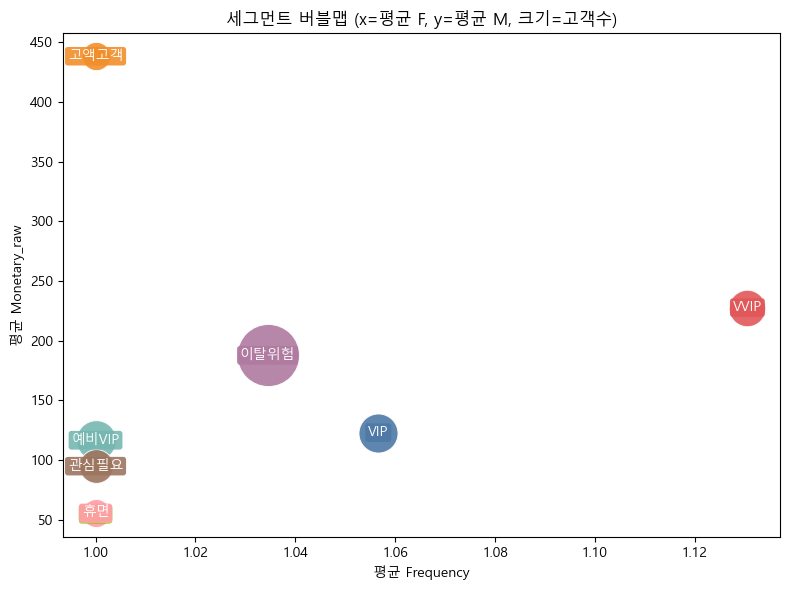

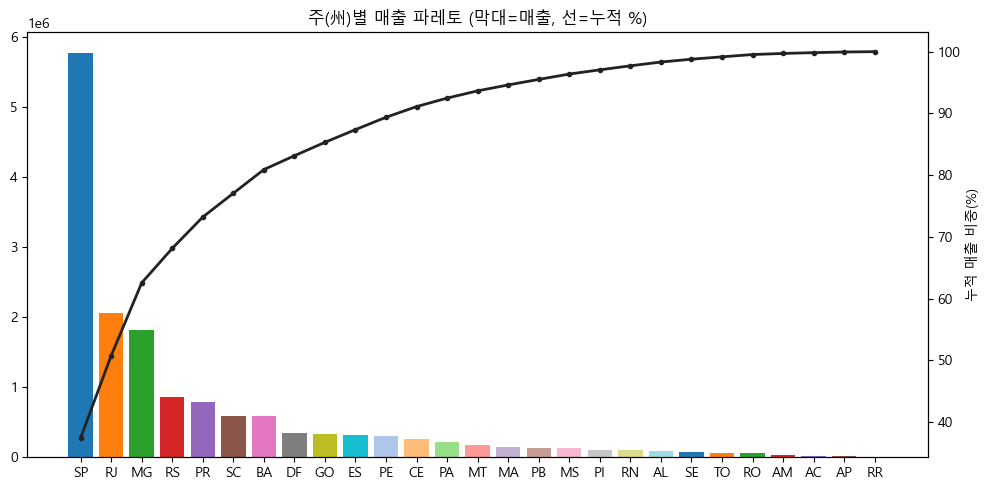

C:\Users\배성우\AppData\Local\Temp\ipykernel_14996\200642065.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2*np.trapz(lorenz, x)


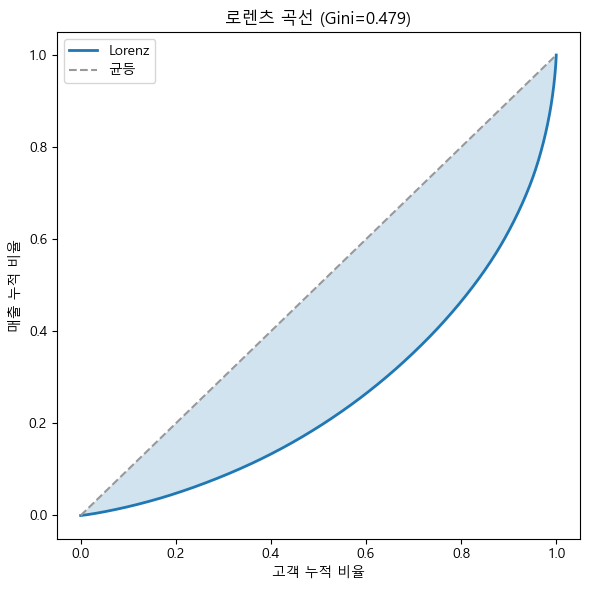

C:\Users\배성우\AppData\Local\Temp\ipykernel_14996\200642065.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=labels, showfliers=False, patch_artist=True)


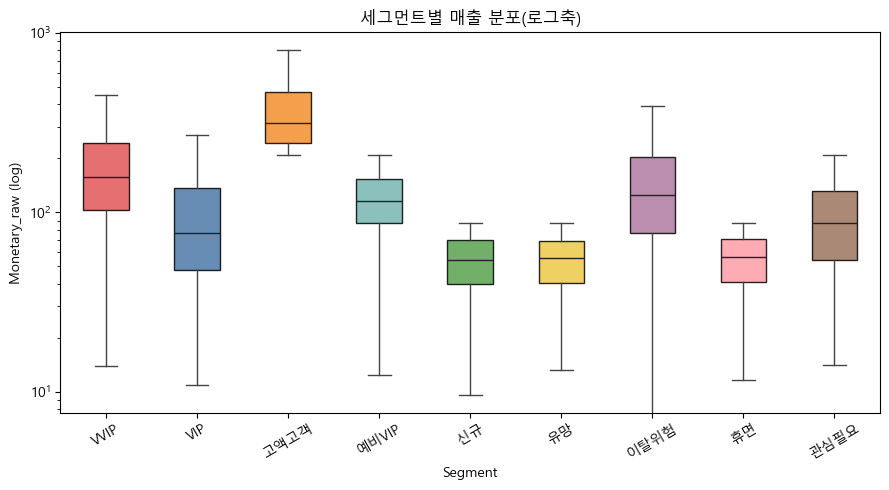

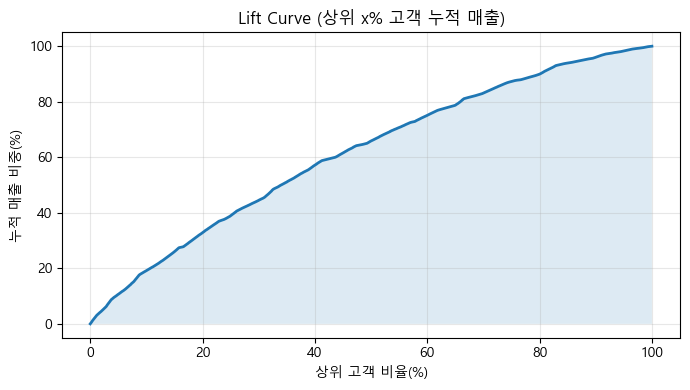

In [12]:
# =========================================================
# (9) 시각화
# - (1) 세그먼트 버블맵
# - (2) 주별 파레토
# - (3) 로렌츠 곡선 & 지니계수
# - (4) 세그먼트별 박스플롯(로그축)
# - (5) Lift Curve
# =========================================================
# (1) 버블맵
_seg = (rfm.groupby("Segment")
          .agg(avgF=("Frequency","mean"),
               avgM=("Monetary_raw","mean"),
               n=("customer_unique_id","nunique"))
          .reset_index())
_seg = _seg[_seg["Segment"].isin(present_segments)].copy()
_seg["Segment"] = pd.Categorical(_seg["Segment"], categories=seg_order, ordered=True)
_seg = _seg.sort_values("Segment")

plt.figure(figsize=(8,6))
sizes = (_seg["n"]/_seg["n"].max()*2000).clip(80, 2200).values
for i, r in _seg.reset_index(drop=True).iterrows():
    plt.scatter(r["avgF"], r["avgM"], s=sizes[i],
                color=seg_colors.get(r["Segment"], "#333333"), alpha=0.9, edgecolor="white", linewidth=0.7)
    plt.text(r["avgF"], r["avgM"], r["Segment"], ha="center", va="center", fontsize=10, color="white",
             bbox=dict(boxstyle="round,pad=0.2", fc=seg_colors.get(r["Segment"], "#333333"), ec="none", alpha=0.9))
plt.title("세그먼트 버블맵 (x=평균 F, y=평균 M, 크기=고객수)")
plt.xlabel("평균 Frequency"); plt.ylabel("평균 Monetary_raw")
plt.tight_layout(); plt.show()

# (2) 주별 파레토
plt.figure(figsize=(10,5))
plt.bar(state_df["customer_state"], state_df["sales"], color=_get_cat_colors(len(state_df)))
ax2 = plt.twinx()
ax2.plot(state_df["customer_state"], state_df["cum_share"], color="#222222", linewidth=2.0, marker="o", markersize=3)
plt.title("주(州)별 매출 파레토 (막대=매출, 선=누적 %)")
plt.xlabel("State"); plt.xticks(rotation=30)
plt.ylabel("매출"); ax2.set_ylabel("누적 매출 비중(%)")
plt.tight_layout(); plt.show()

# (3) 로렌츠 & 지니
vals = np.sort(rfm["Monetary_raw"].to_numpy())
vals = vals[~np.isnan(vals)]
if vals.size > 0 and vals.sum() > 0:
    cum_vals = np.cumsum(vals)
    lorenz = np.insert(cum_vals, 0, 0)/cum_vals[-1]
    x = np.linspace(0.0, 1.0, lorenz.size)
    gini = 1 - 2*np.trapz(lorenz, x)
    plt.figure(figsize=(6,6))
    plt.plot(x, lorenz, label="Lorenz", linewidth=2)
    plt.fill_between(x, lorenz, x, alpha=0.2)
    plt.plot([0,1],[0,1], linestyle="--", color="#999999", label="균등")
    plt.title(f"로렌츠 곡선 (Gini={gini:.3f})")
    plt.xlabel("고객 누적 비율"); plt.ylabel("매출 누적 비율")
    plt.legend(); plt.tight_layout(); plt.show()

# (4) 세그먼트별 박스플롯(로그축)
labels = [s for s in seg_order if s in rfm["Segment"].unique()]
data = [rfm.loc[rfm["Segment"]==s, "Monetary_raw"].dropna().values for s in labels]
plt.figure(figsize=(9,5))
bp = plt.boxplot(data, labels=labels, showfliers=False, patch_artist=True)
for patch, lab in zip(bp["boxes"], labels):
    patch.set_facecolor(seg_colors.get(lab, "#888888")); patch.set_alpha(0.85)
for w in bp["whiskers"]: w.set_color("#444444")
for c in bp["caps"]:     c.set_color("#444444")
for m in bp["medians"]:  m.set_color("#222222")
plt.yscale("log")
plt.title("세그먼트별 매출 분포(로그축)")
plt.xlabel("Segment"); plt.ylabel("Monetary_raw (log)")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

# (5) Lift Curve
idx = np.argsort(-rfm["WeightedScore"].to_numpy())
mon_sorted = rfm["Monetary_raw"].to_numpy()[idx]
if mon_sorted.sum() > 0:
    cum = np.cumsum(mon_sorted)/mon_sorted.sum()
    x = np.linspace(1/len(cum), 1.0, len(cum))*100
    plt.figure(figsize=(7,4))
    plt.plot(x, cum*100, linewidth=2)
    plt.fill_between(x, cum*100, alpha=0.15)
    plt.title("Lift Curve (상위 x% 고객 누적 매출)")
    plt.xlabel("상위 고객 비율(%)"); plt.ylabel("누적 매출 비중(%)")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


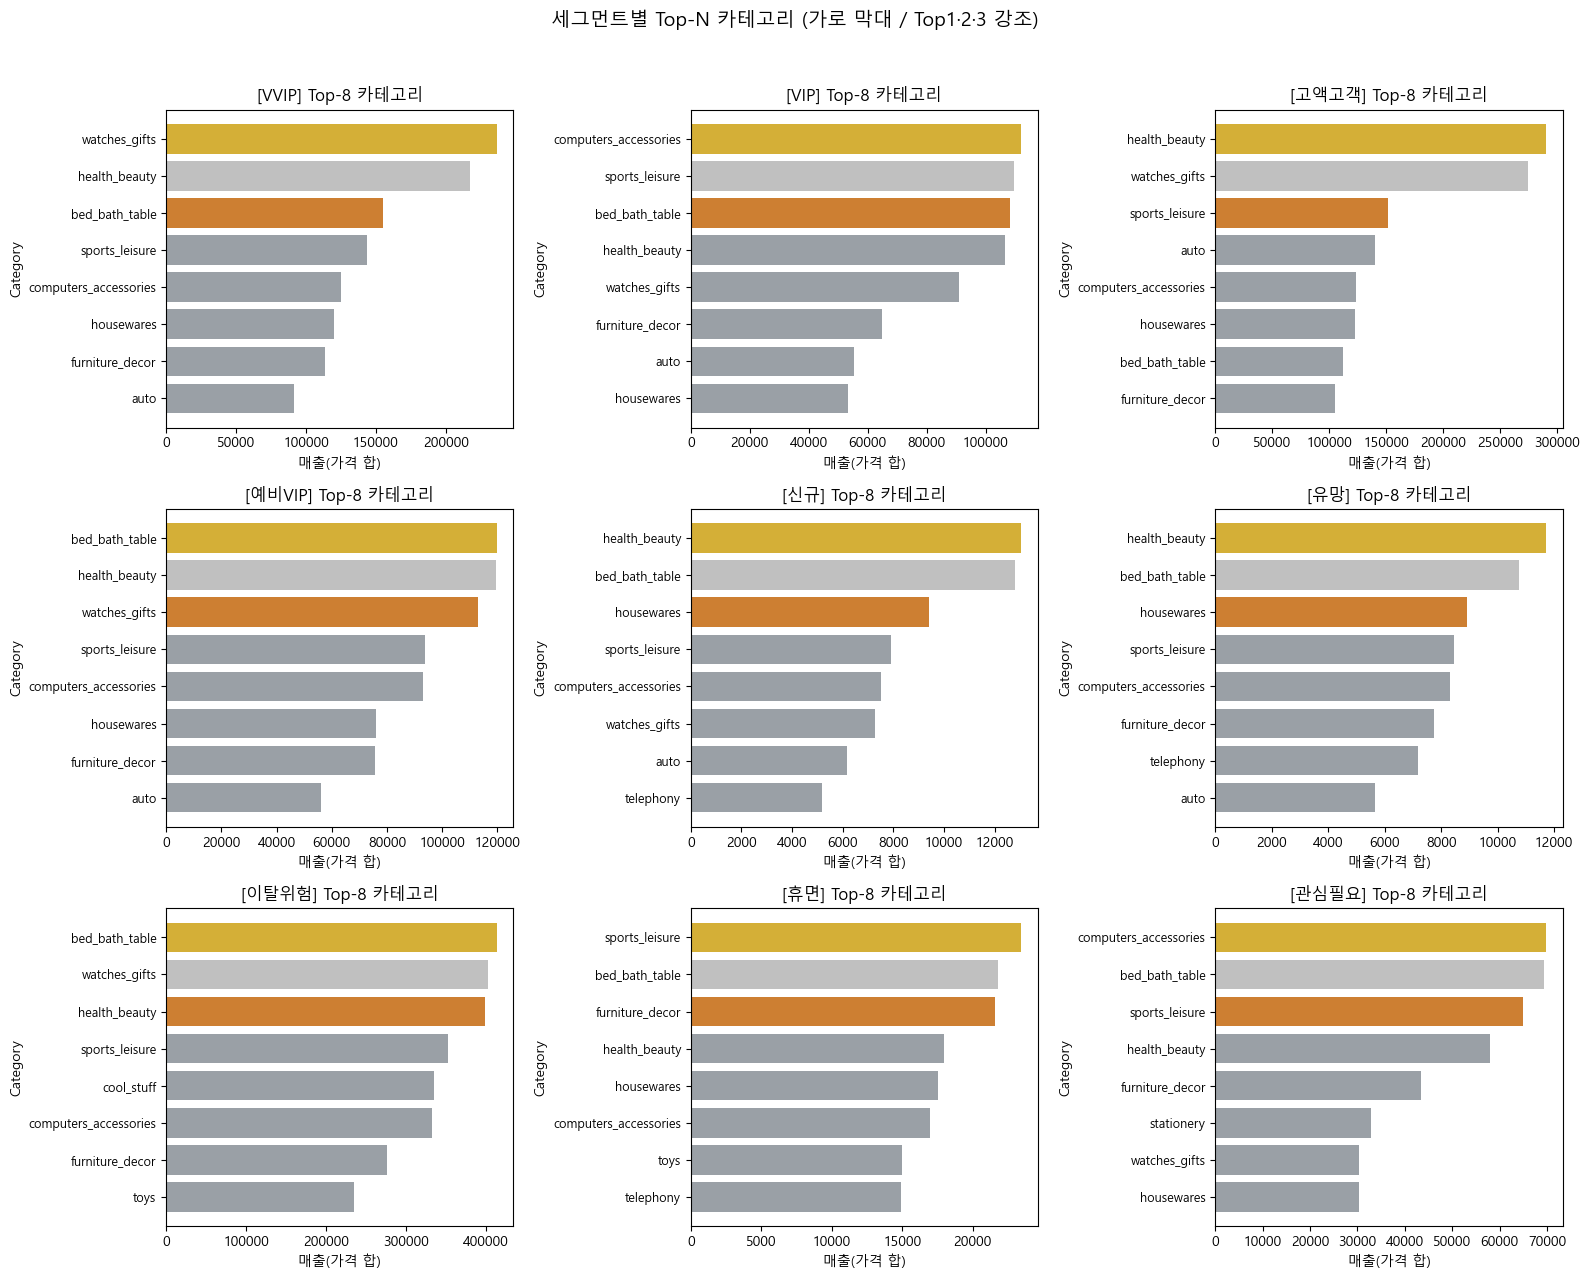

In [13]:
# =========================================================
# (10) 세그먼트×카테고리 Top-N / 주별 도넛  →  서브플롯 2개 Figure로 분리
#  - Figure 1: 세그먼트별 Top-N 카테고리 바 그래프(여러 서브플롯)
#  - Figure 2: 상위 K개 주(州) 도넛(여러 서브플롯)
# =========================================================

_need_cat = {"order_items_clean", "products_clean", "category_tr_clean"}
_miss_cat = [x for x in _need_cat if x not in globals()]
if _miss_cat:
    print(f"⚠️ (세그먼트×카테고리)용 DataFrame 없음: {_miss_cat} — 이 부분만 건너뜁니다.")
else:
    # ---------- 공통 준비 ----------
    # 1) 카테고리 영문명 보장
    if "category_en" not in products_clean.columns:
        cat_map = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
        products_clean = products_clean.copy()
        products_clean["category_en"] = products_clean["product_category_name"].map(cat_map).fillna("unknown")

    # 2) 주문별 Segment 매핑 (배송완료만 사용)
    oc2 = orders_clean.merge(
        customers_clean[["customer_id","customer_unique_id"]], on="customer_id", how="left"
    ).merge(
        rfm[["customer_unique_id","Segment"]], on="customer_unique_id", how="left"
    )
    delivered_ids = oc2.loc[oc2["order_status"]=="delivered", ["order_id","Segment"]]

    # 3) 아이템×카테고리 결합 → 세그먼트×카테고리 매출 집계
    oi = order_items_clean.merge(products_clean[["product_id","category_en"]], on="product_id", how="left")
    oi["category_en"] = oi["category_en"].fillna("unknown")
    oi["price"] = pd.to_numeric(oi["price"], errors="coerce")
    oi_seg = oi.merge(delivered_ids, on="order_id", how="inner")
    seg_cat = (oi_seg.groupby(["Segment","category_en"])["price"]
                     .sum()
                     .reset_index()
                     .rename(columns={"price":"sales"}))

    # 4) 표시 파라미터
    TOPN = 8   # 세그먼트별 상위 카테고리 개수
    K    = 6   # 도넛에 표시할 상위 주 개수

    # 5) 사용할 세그먼트(정렬 유지)
    segments_present = [s for s in seg_order if s in rfm["Segment"].unique()]
    if not segments_present:
        segments_present = sorted(rfm["Segment"].dropna().unique().tolist())

# =========================================================
# Figure 1: 세그먼트별 Top-N 카테고리 바 그래프 (서브플롯)
# - 상위 1,2,3만 색상 차별 (Gold/Silver/Bronze), 나머지 중립색
# =========================================================
import numpy as np
import matplotlib.pyplot as plt

# 색상 설정
COL_GOLD   = "#D4AF37"
COL_SILVER = "#C0C0C0"
COL_BRONZE = "#CD7F32"
COL_NEUTRAL = "#9AA0A6"  # 나머지 막대

n_seg  = len(segments_present)
ncols1 = 3 if n_seg >= 6 else 2
nrows1 = int(np.ceil(n_seg / ncols1))

fig1, axes1 = plt.subplots(nrows1, ncols1, figsize=(16, 4 + 3*nrows1), squeeze=False)

for i, seg_name in enumerate(segments_present):
    r, c = divmod(i, ncols1)
    ax = axes1[r, c]

    d = (seg_cat[seg_cat["Segment"]==seg_name]
            .sort_values("sales", ascending=False)
            .head(TOPN)
            .sort_values("sales"))  # 가로막대: 아래→위로
    if d.empty:
        ax.text(0.5, 0.5, f"[{seg_name}] 데이터 없음", ha="center", va="center")
        ax.set_axis_off()
        continue

    # 막대별 색상: 상위 1,2,3만 골드/실버/브론즈, 나머지는 중립색
    # d는 sales 오름차순 정렬이므로, 마지막 3개가 1·2·3위에 해당
    colors = [COL_NEUTRAL] * len(d)
    if len(d) >= 1: colors[-1] = COL_GOLD      # 1위
    if len(d) >= 2: colors[-2] = COL_SILVER    # 2위
    if len(d) >= 3: colors[-3] = COL_BRONZE    # 3위

    ax.barh(d["category_en"], d["sales"], color=colors)
    ax.set_title(f"[{seg_name}] Top-{TOPN} 카테고리")
    ax.set_xlabel("매출(가격 합)")
    ax.set_ylabel("Category")
    ax.tick_params(axis="y", labelsize=9)

# 남는 축 비우기
total_axes1 = nrows1 * ncols1
if n_seg < total_axes1:
    for j in range(n_seg, total_axes1):
        r, c = divmod(j, ncols1)
        axes1[r, c].set_axis_off()

fig1.suptitle("세그먼트별 Top-N 카테고리 (가로 막대 / Top1·2·3 강조)", fontsize=14, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


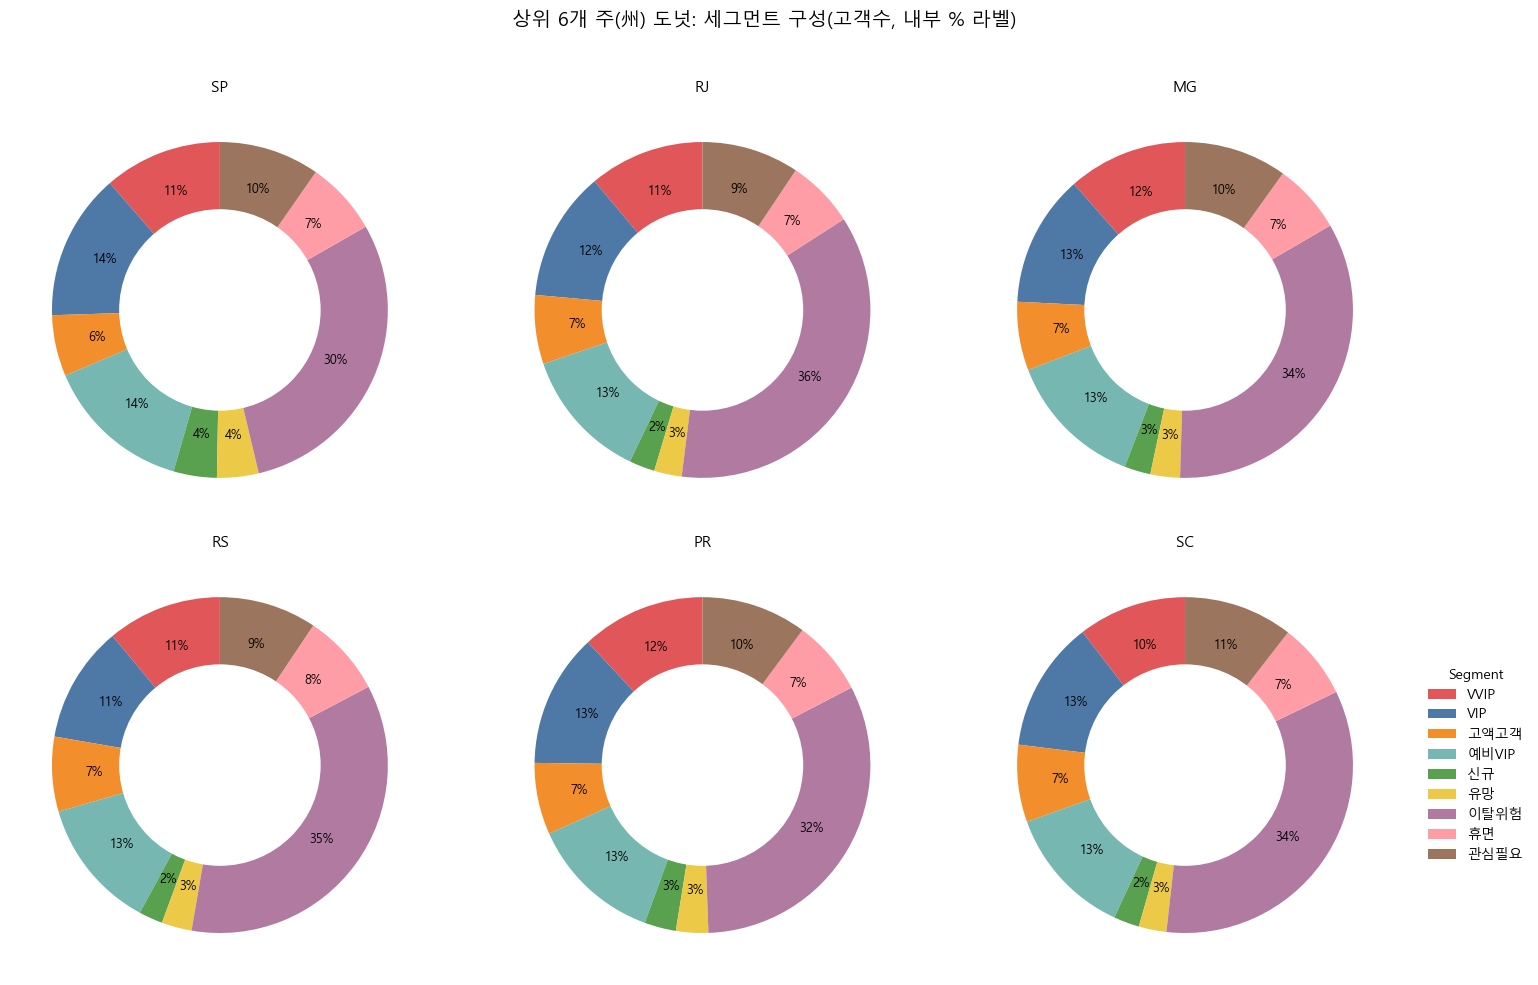

In [14]:

# =========================================================
# Figure 2: 상위 K개 주(州) 도넛 (서브플롯)
# - 도넛 내부에 'xx%' 표기 (작은 비율은 숨김 옵션)
# =========================================================

top_states = state_df.head(K)["customer_state"].tolist()
if not top_states:
    print("⚠️ 도넛용 주(州) 데이터가 비었습니다.")
else:
    n_st   = len(top_states)
    ncols2 = 3
    nrows2 = int(np.ceil(n_st / ncols2))

    # 아주 작은 조각의 % 라벨은 가독성 위해 숨김
    MIN_PCT_SHOW = 2  # 2% 미만은 라벨 숨김 (원하면 0으로)
    def _autopct_fmt(pct):
        return f"{pct:.0f}%" if pct >= MIN_PCT_SHOW else ""

    fig2, axes2 = plt.subplots(nrows2, ncols2, figsize=(16, 4 + 3*nrows2), squeeze=False)

    for j, st in enumerate(top_states):
        r, c = divmod(j, ncols2)
        ax = axes2[r, c]

        counts = (rfm.loc[rfm["customer_state"]==st]
                    .groupby("Segment")["customer_unique_id"]
                    .nunique()
                    .reindex(segments_present)  # 세그먼트 순서 고정
                    .fillna(0))

        if counts.sum() == 0:
            ax.text(0.5, 0.5, f"{st}\n데이터 없음", ha="center", va="center")
            ax.set_axis_off()
            continue

        # 색상(있으면 사용)
        colors = [seg_colors.get(s, "#777777") for s in counts.index] if "seg_colors" in globals() else None

        wedges, texts, autotexts = ax.pie(
            counts.values,
            startangle=90,
            colors=colors,
            autopct=_autopct_fmt,    # 'xx%' 라벨
            pctdistance=0.75,        # 라벨을 도넛 링 안쪽에 위치
            textprops={"fontsize": 9}
        )

        # 도넛(중앙 구멍)
        centre = plt.Circle((0,0), 0.60, fc="white")
        ax.add_artist(centre)

        ax.set_title(f"{st}", fontsize=11)

    # 남는 축 비우기
    total_axes2 = nrows2 * ncols2
    if n_st < total_axes2:
        for j in range(n_st, total_axes2):
            r, c = divmod(j, ncols2)
            axes2[r, c].set_axis_off()

    # 우측 아래 여백에 범례 1개(공용) 추가 (가능할 때만)
    try:
        if "seg_colors" in globals():
            # 마지막 유효 축에 범례 배치
            last_ax = axes2[-1, -1]
            last_ax.legend(
                wedges, segments_present, title="Segment",
                bbox_to_anchor=(1.05, 0.5), loc="center left", frameon=False
            )
    except Exception:
        pass

    fig2.suptitle(f"상위 {K}개 주(州) 도넛: 세그먼트 구성(고객수, 내부 % 라벨)", fontsize=14, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [15]:
# a/b/c 중 하나가 float가 아니라 matplotlib 객체(Line2D 등)라서
# f-string의 {:.2f} 포맷을 적용할 수 없어서 발생합니다.

# --- 안전한 출력: 변수명 충돌 회피 + float 강제 ---
alpha_w = float(_best['alpha'])
beta_w  = float(_best['beta'])
gamma_w = float(_best['gamma'])

# --- (선택) 타입 점검 헬퍼: 혹시 다른 셀에서 a/b/c가 무엇으로 덮였는지 확인 ---
for name in ['a','b','c']:
    if name in globals():
        print(name, type(globals()[name]))


a <class 'numpy.float64'>
b <class 'numpy.float64'>
c <class 'int'>


In [16]:
# a/b/c 중 하나가 float가 아니라 matplotlib 객체(Line2D 등)라서
# f-string의 {:.2f} 포맷을 적용할 수 없어서 발생합니다.

# --- 안전한 출력: 변수명 충돌 회피 + float 강제 ---
alpha_w = float(_best['alpha'])
beta_w  = float(_best['beta'])
gamma_w = float(_best['gamma'])

print(f"기준일(base) = {_base_date} / 최적 가중치: R={alpha_w:.2f}, F={beta_w:.2f}, M={gamma_w:.2f}  (단조충족: {_best.get('mono')})")
print("\n[Class 요약]")
display(class_summary)
print("\n[세그먼트 요약]")
display(segment_summary)
print("\n[세그먼트 권장 액션]")
display(segment_actions_df)


기준일(base) = 2018-08-29 / 최적 가중치: R=0.40, F=0.30, M=0.30  (단조충족: True)

[Class 요약]


,Class,고객수,매출액,매출비중(%)
0,1,18672,5062307,32.82
1,2,18671,3694223,23.95
2,3,18672,2857068,18.53
3,4,18671,2281526,14.79
4,5,18672,1527337,9.90



[세그먼트 요약]


,Segment,고객수,매출액,평균R,평균F,평균M,Recency_평균,Frequency_평균,Monetary_평균,매출비중(%)
1,VVIP,10578,2409676.90,4.620628,4.577236,3.744848,81.605029,1.130554,227.800804,15.62
0,VIP,12096,1488623.08,3.470899,4.441303,2.496941,182.498925,1.056630,123.067384,9.65
2,고액고객,6354,2785481.17,4.030689,2.004879,5.000000,134.331130,1.000000,438.382306,18.06
5,예비VIP,12485,1457135.47,4.500761,2.237085,3.002243,92.338807,1.000000,116.710891,9.45
4,신규,2948,161494.02,5.000000,1.507123,1.494912,45.450475,1.000000,54.780875,1.05
6,유망,2997,164862.88,4.000000,1.491491,1.501835,138.607608,1.000000,55.009303,1.07
7,이탈위험,30591,5746175.65,1.503841,3.294989,3.273446,396.442418,1.034455,187.838765,37.26
8,휴면,6261,349530.57,1.495608,1.500240,1.515732,398.462386,1.000000,55.826636,2.27
3,관심필요,9048,859482.03,3.000000,2.007294,2.483311,222.707560,1.000000,94.991383,5.57



[세그먼트 권장 액션]


,Segment,권장액션
0,VVIP,"VIP전용 혜택, 프리오더, 리퍼럴 보상, 멤버십 유지 인센티브, 고마진 번들"
1,VIP,"구독/정기배송, 교차판매, 기념일 쿠폰, 리뷰/UGC 유도"
2,고액고객,"프리미엄 업셀/애드온, 컨시어지 상담, 빠른/무료 배송, 한정판 초대"
3,예비VIP,"N+1 재구매 쿠폰, 온보딩 시리즈, 장바구니 리마인드, 적립금 만료알림"
4,신규,"웰컴 시리즈, 초보/사이즈 가이드, 첫 재구매 쿠폰, 간편반품 안내"
5,유망,"인기/시즌 추천, 소액 인센티브(배송비 쿠폰), 개인화 추천"
6,이탈위험,"윈백(강한 인센티브), 재입고/가격하락 알림, CS 이슈 점검"
7,휴면,"분기 리마인드, 1회성 리액티베이션 후 비반응 억제"
8,관심필요,"개인화 추천, 마이크로 인센티브, 콘텐츠 노출 확대"


In [17]:
import os, pickle
import pandas as pd

SNAP_DIR = "_snapshots"
BUNDLE_PATH = os.path.join(SNAP_DIR, "olist_clean_bundle.pkl")

# 0) 안전장치: rfm이 DataFrame인지 확인
assert isinstance(rfm, pd.DataFrame), "rfm은 pandas.DataFrame 이어야 합니다."

# 1) 기존 번들 로드
with open(BUNDLE_PATH, "rb") as f:
    bundle = pickle.load(f)

# 2) rfm 추가(덮어쓰기 허용)
bundle["rfm"] = rfm

# 3) 원자적 저장: 임시 파일에 쓰고 rename
tmp_path = BUNDLE_PATH + ".tmp"
with open(tmp_path, "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)
os.replace(tmp_path, BUNDLE_PATH)  # 같은 파일로 교체

print("✅ Updated bundle ->", BUNDLE_PATH)
print({k: getattr(v, "shape", None) for k, v in bundle.items()})

✅ Updated bundle -> _snapshots\olist_clean_bundle.pkl
{'orders_clean': (99441, 9), 'order_items_clean': (112650, 9), 'payments_clean': (103877, 6), 'reviews_clean': (99224, 7), 'customers_clean': (99441, 5), 'geolocation_clean': (1000163, 5), 'products_clean': (32951, 10), 'sellers_clean': (3095, 4), 'category_tr_clean': (71, 2), 'rfm': (93358, 12)}


### 상위 세그먼트 분석

In [28]:
# ── 세그먼트 매출 집계 ─────────────────────────────────────────
seg_order = ["VVIP","VIP","고액고객","예비VIP","신규","유망","이탈위험","휴면","관심필요"]

seg_sales = (rfm.groupby("Segment")["Monetary_raw"]
               .sum()
               .reindex(seg_order)
               .fillna(0.0))
total_sales = float(seg_sales.sum())

upper_segments = ["VVIP","VIP","고액고객"]
upper_present = [s for s in upper_segments if s in seg_sales.index and seg_sales[s] > 0]

upper_sum      = float(seg_sales.loc[upper_present].sum())
upper_share_pct = (upper_sum / total_sales * 100.0) if total_sales > 0 else 0.0

# 시각화용 데이터프레임
bar_df = (seg_sales / total_sales).reset_index()
bar_df.columns = ["Segment", "share"]

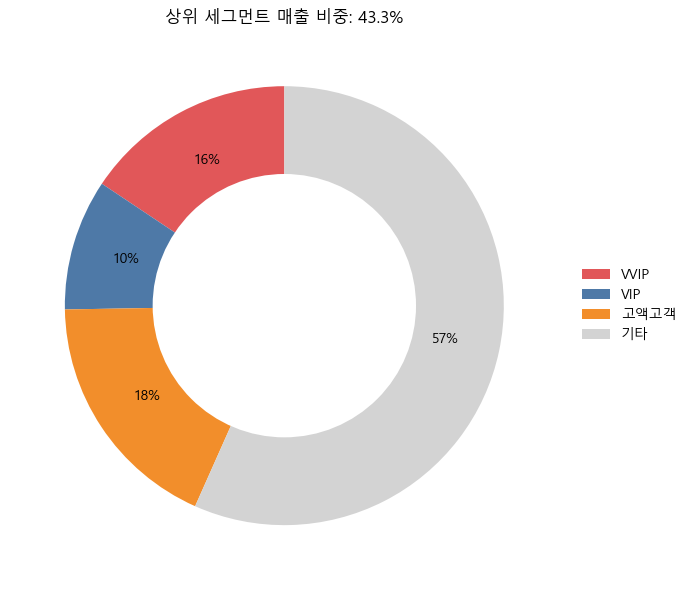

In [34]:
labels = upper_present + ["기타"]
values = [float(seg_sales[s]) for s in upper_present] + [float(total_sales - upper_sum)]
colors = [seg_colors.get(s, "#777777") for s in upper_present] + ["#D3D3D3"]

plt.figure(figsize=(8, 6))
wedges, txts, autotxts = plt.pie(
    values,
    labels=None,
    autopct=lambda p: f"{p:.0f}%",
    startangle=90,
    colors=colors,
    pctdistance=0.75,
    textprops={"fontsize": 10}
)
# 도넛 구멍
centre = plt.Circle((0,0), 0.60, fc="white")
plt.gca().add_artist(centre)

plt.title(f"상위 세그먼트 매출 비중: {upper_share_pct:.1f}%")
plt.legend(wedges, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.show()


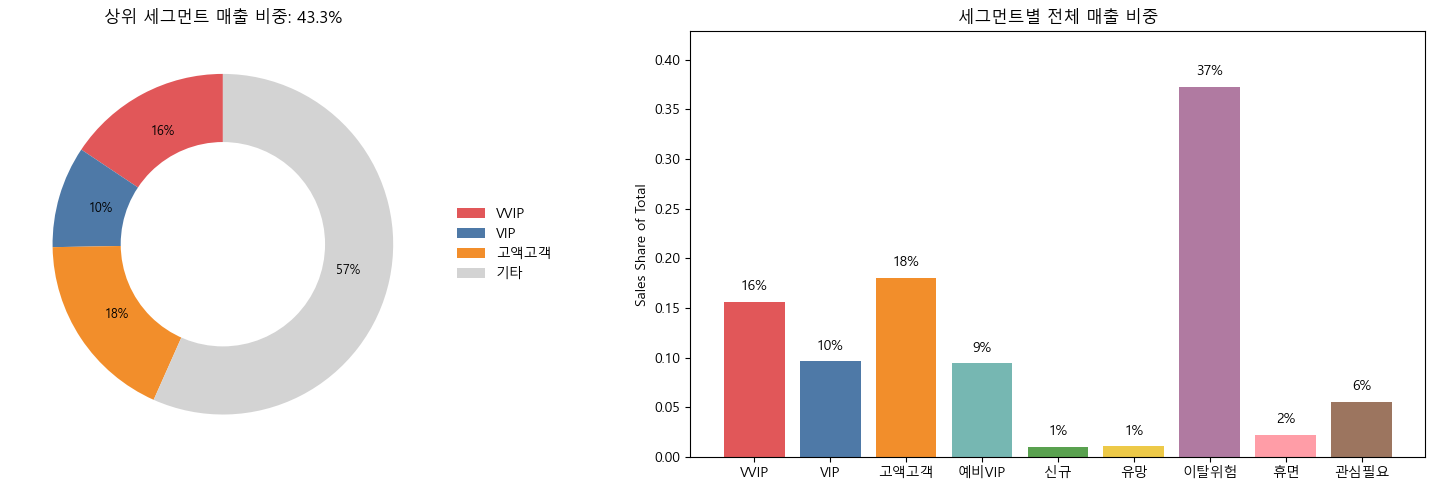

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# 색상 (세그먼트)
seg_colors = {
    "VVIP":"#E15759","VIP":"#4E79A7","고액고객":"#F28E2B","예비VIP":"#76B7B2",
    "신규":"#59A14F","유망":"#EDC948","이탈위험":"#B07AA1","휴면":"#FF9DA7","관심필요":"#9C755F",
}

# ── (좌) 도넛: 상위 3세그먼트 vs 기타 ──────────────────────────
labels = upper_present + ["기타"]
values = [float(seg_sales[s]) for s in upper_present] + [float(total_sales - upper_sum)]
colors = [seg_colors.get(s, "#777777") for s in upper_present] + ["#D3D3D3"]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ax = axes[0]
wedges, txts, autotxts = ax.pie(values, labels=None, autopct=lambda p: f"{p:.0f}%",
                                startangle=90, colors=colors, pctdistance=0.75,
                                textprops={"fontsize": 9})
# 도넛 구멍
centre = plt.Circle((0,0), 0.60, fc="white")
ax.add_artist(centre)
ax.set_title(f"상위 세그먼트 매출 비중: {upper_share_pct:.1f}%")

# 범례
legend_labels = [*upper_present, "기타"]
ax.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

# ── (우) 막대: 세그먼트별 전체 매출 비중 ────────────────────────
ax = axes[1]
plot_df = bar_df[bar_df["share"] > 0].copy()
ax.bar(plot_df["Segment"], plot_df["share"],
       color=[seg_colors.get(s, "#666666") for s in plot_df["Segment"]])
ax.set_ylim(0, max(0.01, plot_df["share"].max()*1.15))
ax.set_title("세그먼트별 전체 매출 비중")
ax.set_ylabel("Sales Share of Total")
for i, (x, y) in enumerate(zip(plot_df["Segment"], plot_df["share"])):
    ax.text(i, y + ax.get_ylim()[1]*0.02, f"{y*100:.0f}%", ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.show()

In [30]:
# ── category_en 보장 ──────────────────────────────────────────
if "category_en" not in products_clean.columns:
    cat_map = category_tr_clean.set_index("product_category_name")["product_category_name_english"].to_dict()
    products_clean = products_clean.copy()
    products_clean["category_en"] = products_clean["product_category_name"].map(cat_map).fillna("unknown")

# ── 배송완료 주문의 세그먼트 매핑 ────────────────────────────────
oc2 = (orders_clean
       .merge(customers_clean[["customer_id","customer_unique_id"]], on="customer_id", how="left")
       .merge(rfm[["customer_unique_id","Segment"]], on="customer_unique_id", how="left"))
delivered = oc2.loc[oc2["order_status"]=="delivered", ["order_id","Segment"]]

# ── 아이템×카테고리 결합 → 세그먼트×카테고리 매출 ───────────────
oi = order_items_clean.merge(products_clean[["product_id","category_en"]], on="product_id", how="left")
oi["price"] = pd.to_numeric(oi["price"], errors="coerce")
seg_cat = (oi.merge(delivered, on="order_id", how="inner")
             .groupby(["Segment","category_en"], as_index=False)["price"].sum()
             .rename(columns={"price":"sales"}))

# ── 상위 3개 카테고리 (세그먼트 내부 비중 %) ───────────────────
def top3_for(seg_name: str):
    d = seg_cat[seg_cat["Segment"]==seg_name].copy()
    if d.empty:
        return d.assign(pct=[])
    total = float(d["sales"].sum()) or 1.0
    d["pct"] = d["sales"] / total * 100.0
    return d.sort_values("sales", ascending=False).head(3)

top3_map = {seg: top3_for(seg) for seg in upper_present}
for seg, d in top3_map.items():
    display(d.assign(pct=lambda x: x["pct"].round(1)))


,Segment,category_en,sales,pct
135,VVIP,watches_gifts,236518.83,11.4
109,VVIP,health_beauty,217589.60,10.5
75,VVIP,bed_bath_table,155103.50,7.5


,Segment,category_en,sales,pct
14,VIP,computers_accessories,112069.47,9.0
61,VIP,sports_leisure,109550.65,8.8
7,VIP,bed_bath_table,108283.47,8.7


,Segment,category_en,sales,pct
172,고액고객,health_beauty,289996.65,11.5
197,고액고객,watches_gifts,274295.01,10.9
192,고액고객,sports_leisure,151258.47,6.0


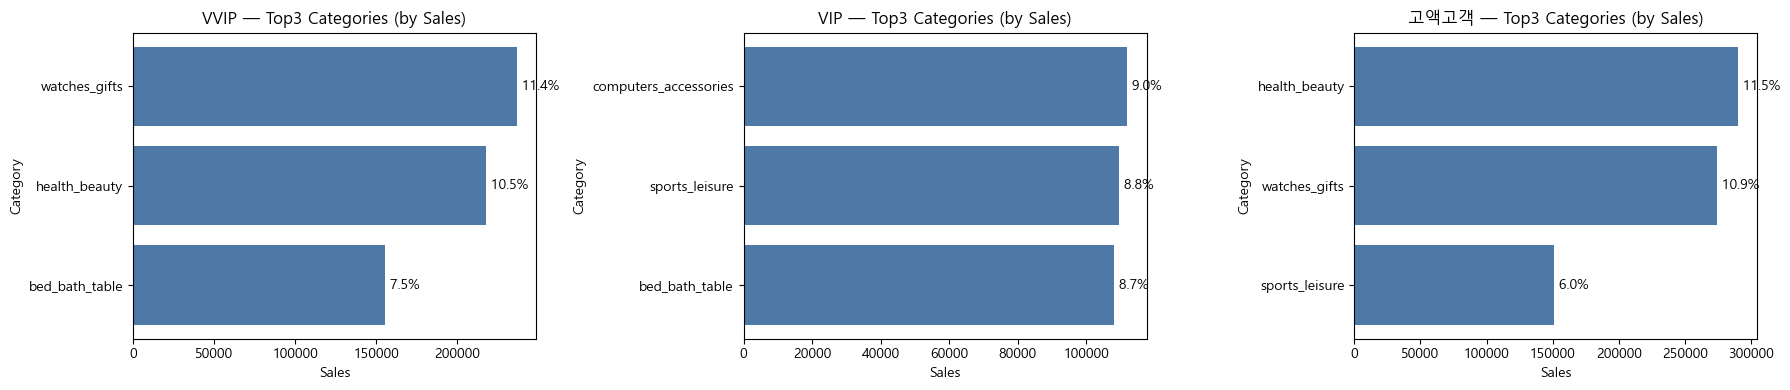

In [35]:
# ── 서브플롯 1행3열: 각 세그먼트 Top3 ───────────────────────────
n = len(upper_present)
if n == 0:
    print("상위 세그먼트 데이터가 없습니다.")
else:
    fig, axes = plt.subplots(1, n, figsize=(6*n, 4), squeeze=False)
    for i, seg in enumerate(upper_present):
        ax = axes[0, i]
        d = top3_map[seg].sort_values("sales", ascending=True)  # 가로막대: 아래→위
        if d.empty:
            ax.text(0.5, 0.5, f"[{seg}] 데이터 없음", ha="center", va="center")
            ax.set_axis_off()
            continue
        ax.barh(d["category_en"], d["sales"], color="#4E79A7")
        # 퍼센트 라벨 (세그먼트 내부 비중)
        for y, (cat, s, p) in enumerate(zip(d["category_en"], d["sales"], d["pct"])):
            ax.text(s, y, f" {p:.1f}%", va="center")
        ax.set_title(f"{seg} — Top3 Categories (by Sales)")
        ax.set_xlabel("Sales")
        ax.set_ylabel("Category")
    plt.tight_layout()
    plt.show()


### 총 거래액 계산

In [ ]:
# =========================================================
# - 베이스 결합 + 상태 필터 + 월 집계 & 완전월 판정
# - 포함 상태: delivered / invoiced / shipped / processing / created
# - "완전월": 그 달의 모든 날짜가 데이터에 존재하는 달
# =========================================================

valid_status = ["delivered","invoiced","shipped","processing","created"]

# 주문-아이템 결합 후 상태 필터
base = (orders_clean[["order_id","order_purchase_timestamp","order_status"]]
        .merge(order_items_clean[["order_id","price"]], on="order_id", how="inner"))
base = base[base["order_status"].isin(valid_status)].copy()
base["order_purchase_timestamp"] = pd.to_datetime(base["order_purchase_timestamp"], errors="coerce")

# 월 컬럼
base["order_month"] = base["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

# (1) 월별 GMV 집계
month_gmv = base.groupby("order_month")["price"].sum().sort_index()

# (2) 월 커버리지로 완전월 판정
g = base.groupby(base["order_purchase_timestamp"].dt.to_period("M"))
cov = g["order_purchase_timestamp"].agg(
    first_date="min",
    last_date="max",
    days_covered=lambda s: s.dt.normalize().nunique()  # 해당 월에 실제 존재하는 '날짜' 수
).reset_index()

cov["month_start"]  = cov["order_purchase_timestamp"].dt.to_timestamp()
cov["month_length"] = cov["first_date"].dt.days_in_month
cov["is_complete"]  = cov["days_covered"] >= cov["month_length"]

# 완전월 인덱스
complete_months = cov.loc[cov["is_complete"], "month_start"].sort_values()


In [ ]:
# =========================================================
# - 분석 구간 + 3M 이동평균 + (옵션) 2018-09 예측(3M MA)
# - 실측은 '완전월'만 사용
# - 3개월 이동평균(3M MA): rolling(3, min_periods=1).mean()
# - 2018-09 예측: 마지막 3개월 실측 평균(간단 MA 예측)
# =========================================================

# 완전월만 사용
gmv_complete = month_gmv[month_gmv.index.isin(complete_months)].copy()

# 분석 컷오프(2018-08 포함)
cutoff_month = pd.Timestamp("2018-08-01")
gmv_upto_aug = gmv_complete[gmv_complete.index <= cutoff_month]

# 3개월 이동평균(선형 보간 없이 단순 평균)
gmv_ma3 = gmv_upto_aug.rolling(3, min_periods=1).mean()

# (옵션) 2018-09 예측치(3M MA)
FORECAST_SEP = True
sep_month = pd.Timestamp("2018-09-01")
sep_forecast = None
if FORECAST_SEP and len(gmv_upto_aug) >= 3:
    sep_forecast = float(gmv_upto_aug.iloc[-3:].mean())


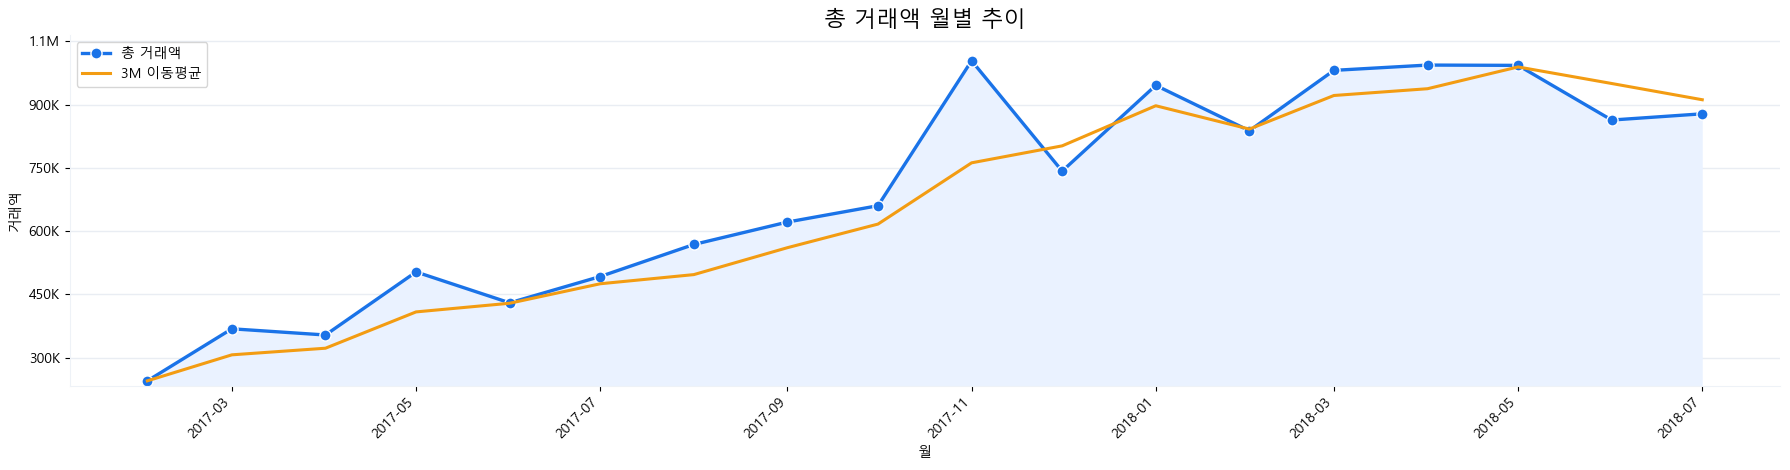

In [ ]:
# =========================================================
# - (A) 2018-08까지 실측 + 3M 이동평균선
# - 실측 라인 + 포인트 + 면적 채움
# - 3M MA 라인(겹쳐 그리기)
# =========================================================
import matplotlib.ticker as mticker

# 테마 색상
BG_FIG = "#ffffff"
BG_AX  = "#ffffff"
LINE_REAL = "#1a73e8"  # 실측
FILL      = "#eaf2ff"
LINE_MA3  = "#f39c12"  # 3M 이동평균(주황)

# 데이터
x = gmv_upto_aug.index
y = gmv_upto_aug.values
y_ma = gmv_ma3.values

# 보조: Y 포맷터
def human_fmt(v, pos=None):
    if v >= 1_000_000: return f"{v/1_000_000:.1f}M"
    if v >= 1_000:     return f"{v/1_000:.0f}K"
    return f"{int(v)}"

# 그림
fig, ax = plt.subplots(figsize=(18, 4.8), facecolor=BG_FIG)
ax.set_facecolor(BG_AX)
ax.set_axisbelow(True)

# 면적(실측 아래 채움)
baseline = min(y.min()*0.98, y.min()*0.95)
ax.fill_between(x, y, baseline, color=FILL, alpha=1.0, linewidth=0)

# 실측: 라인 + 포인트
ax.plot(x, y, color=LINE_REAL, linewidth=2.4, marker="o",
        markersize=8, markerfacecolor=LINE_REAL, markeredgecolor="#ffffff", markeredgewidth=1.0,
        label="총 거래액")

# 3M 이동평균선(겹쳐 그리기)
ax.plot(x, y_ma, color=LINE_MA3, linewidth=2.2, linestyle="-", marker=None, label="3M 이동평균")

# 격자/스파인/축 라벨
ax.grid(axis='y', color="#e9edf3", linewidth=1.0)
ax.grid(axis='x', visible=False)
for s in ["top","right"]:
    ax.spines[s].set_visible(False)
ax.spines["left"].set_color("#eef2f7")
ax.spines["bottom"].set_color("#eef2f7")
ax.set_title("총 거래액 월별 추이", fontsize=16)
ax.set_xlabel("월")
ax.set_ylabel("거래액")
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(human_fmt))
ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6))
ax.set_ylim(baseline, max(y.max(), y_ma.max())*1.06)

ax.legend(loc="upper left")
plt.tight_layout()
plt.show()
